Tic Tac Toe
---
Two players against each other

<img style="float:left" src="board.png" alt="drawing" width="200"/>

In [1]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import multiprocessing
import matplotlib.pyplot as plt
import collections
from time import perf_counter
import cProfile
import glob

from TicTacToe import *
%load_ext snakeviz

In [2]:
BOARD_ROWS = 3
BOARD_COLS = 3
WIN = 3  # To score a point
MAX_SCORE = 1  # Minimum of points to win the game
assert WIN <= min(BOARD_ROWS, BOARD_COLS)

In [3]:
np.random.seed(seed=42)

### Board State
---
Reflect & Judge the state

2 players p1 and p2; p1 uses symbol 1 and p2 uses symbol 2, vacancy as 0

In [4]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS), dtype=np.int8)
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1
        self.available_positions = {j+i*BOARD_COLS: (i, j) for i in range(BOARD_ROWS) for j in range(BOARD_COLS)}
        self.results = {
            'played': 0,
            'p1': [],
            'p2': [],
            'tie': []
        }
        self.max_score = 1
    
    def displayMetrics(self):
        # Sanity checks
        assert len(self.results["tie"])+len(self.results["p1"]) + len(self.results["p2"]) == self.results["played"]
        print("[INFO] {} games played".format(self.results["played"]))
        print("P1 won: {} | P2 won: {} | Ties: {}"
              .format(len(self.results["p1"]), len(self.results["p2"]), len(self.results["tie"])))
        
        expand_result = np.zeros((self.results['played'],))
        for game in self.results['p1']:
            expand_result[game[0]] = 1
        for game in self.results['p2']:
            expand_result[game[0]] = -1
        
        """
        # Linear scatter plot
        plt.figure(figsize=(15, 5))
        plt.scatter(range(self.results["played"]), expand_result, alpha=0.1)
        plt.title('Overall training result')
        plt.xlabel('Game number')
        plt.ylabel('Won by')
        
        # Do the same with a semilogx instead
        plt.figure(figsize=(15, 5))
        plt.semilogx(range(self.results["played"]), expand_result, linestyle="", marker=".", alpha=0.1)
        plt.title('Overall training result')
        plt.xlabel('Game number')
        plt.ylabel('Won by')
        """
        
        # Cum sum plot might be better?
        cum_p1 = np.zeros((self.results['played'],))
        cum_p2 = np.zeros((self.results['played'],))
        cum_tie = np.zeros((self.results['played'],))
        if expand_result[0] == 1: cum_p1[0] = 1
        if expand_result[0] == -1: cum_p2[0] = 1
        if expand_result[0] == 0: cum_tie[0] = 1
        for i in range(1, self.results['played']):
            cum_p1[i] = cum_p1[i-1] + 1 if expand_result[i] == 1 else cum_p1[i-1]
            cum_p2[i] = cum_p2[i-1] + 1 if expand_result[i] == -1 else cum_p2[i-1]
            cum_tie[i] = cum_tie[i-1] + 1 if expand_result[i] == 0 else cum_tie[i-1]
        plt.figure(figsize=(15, 5))
        plt.plot(cum_p1, label='Player 1')
        plt.plot(cum_p2, label='Player 2')
        plt.plot(cum_tie, label='Tie')
        plt.legend()
        plt.title("Cumulative win sum")
        plt.xlabel('Game number')
        plt.ylabel('Cumulative score')
        
        # Learning & exploration rate over time
        plt.figure(figsize=(15, 5))
        lr = [self.p1.learningRate(k) for k in range(self.results['played'])]
        explo = [self.p1.explorationRate(k) for k in range(self.results['played'])]
        plt.plot(lr, label='Learning rate')
        plt.plot(explo, label='Exploration rate')
        plt.title('Evolution of the learning & exploration rates')
        plt.xlabel('Game number')
        plt.ylabel('Rate')
        plt.legend()
    
    # get unique hash of current board state
    def getHash(self, method='tostring'):
        if method == 'str':
            self.boardHash = str(self.board.reshape(BOARD_COLS*BOARD_ROWS))
        elif method == 'tostring':
            self.boardHash = self.board.tostring()
        return self.boardHash
    
    def old_winner(self):
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -30:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -30:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS-i-1] for i in range(BOARD_COLS)])
        #diag_sum = max(diag_sum1, diag_sum2)
        if diag_sum1 == 3 or diag_sum2 == 3:
            self.isEnd = True
            return 1
        if diag_sum1 == -30 or diag_sum2 == -30:
            self.isEnd = True
            return -1
        
        # tie
        # no available positions
        if len(self.available_positions) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None

    def winner(self, player):
        """
        Checks if there is a winner already or not by hecking rows, cols and diag on the board.
        The whole board is rechecked, which wastes some time.
        return: 1 of player 1 won, -1 if player 2, 0 if tie
        """
        #print("Checking the board - still {} positions to play".format(len(self.available_positions)))
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) in player.win and player.id == 1:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) in player.win and player.id == 2:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) in player.win and player.id == 1:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) in player.win and player.id == 2:
                self.isEnd = True
                return -1
        
        """Should use hills/dales"""
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS-i-1] for i in range(BOARD_COLS)])
        #diag_sum = max(diag_sum1, diag_sum2)
        if (diag_sum1 in player.win or diag_sum2 in player.win) and player.id == 1:
            self.isEnd = True
            return 1
        if (diag_sum1 in player.win or diag_sum2 in player.win) and player.id == 2:
            self.isEnd = True
            return -1
        
        # tie
        # no available positions
        #if len(self.availablePositions()) == 0:
        if len(self.available_positions) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None
    
    def fastWinner(self, action, player):
        boardCheck.updateScores(self.board.copy(), *action, player, WIN)
        if player.score >= MAX_SCORE:
            if player.id == 1:
                win = 1
            elif player.id == 2:
                win = -1
            else:
                raise ValueError
            #win = 1 if player.id == 1 else -1  # Really not great but works
        elif len(self.available_positions) == 0 and player.score==0:  # Tied
            win = 0
        elif player.score == 0:  # Keep playing
            win = None
        else:
            raise ValueError('Problem! Fix me!')
        return win
    
    """
    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions
    """

    
    def updateState(self, position, player):
        #self.board[position] = self.playerSymbol
        
        # A player always lay a pc1. These can be turned into pc2 if counted in a win
        self.board[position] = player.pc1
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1
    
    # only when game ends
    def giveReward(self, result):
        #result = self.winner()
        # backpropagate reward
        if result == 1:  # p1 won
            self.p1.feedReward(1, self.game_number)
            self.p2.feedReward(0, self.game_number)
        elif result == -1:  # p2 won
            self.p1.feedReward(0, self.game_number)
            self.p2.feedReward(1, self.game_number)
        else:  # There was a tie or the game is still running
            self.p1.feedReward(0.1, self.game_number)
            self.p2.feedReward(0.5, self.game_number)
        
    
    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS), dtype=np.int8)
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1
        self.available_positions = {j+i*BOARD_COLS: (i, j) for i in range(BOARD_ROWS) for j in range(BOARD_COLS)}
        self.p1.score = 0
        self.p2.score = 0
    
    def play(self, rounds=100, save_policies=None, show_board=False):
        for game in tqdm_notebook(range(rounds)):
            self.game_number = game
            if save_policies and game%save_policies == 0 and game != 0:
                print("Saving policy at round {}".format(game))
                self.p1.savePolicy(game)
                self.p2.savePolicy(game)
            #assert not self.isEnd
            turns = 0  # Tracks how many turns were played before a winner was found
            
            while not self.isEnd:
                # Player 1
                #positions = self.availablePositions()
                #p1_action = self.p1.chooseAction(self.available_positions, self.board, self.playerSymbol, self.game_number)
                p1_action = self.p1.chooseAction(self.available_positions, self.board, self.game_number)
                # take action and upate board state
                self.updateState(p1_action, self.p1)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                
                # check board status if it is end

                #win = self.winner(self.p1)
                #win2 = self.old_winner()
                win = self.fastWinner(p1_action, self.p1)
                """
                try:
                    assert win == win2
                except:
                    print("Debug: win != win2")
                    print(win, win2)
                    print(self.board)
                    print(p1_action)
                    print(p1.win)
                    raise
                """

                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    if win == 1:
                        self.results['p1'].append((game, turns))
                        #print("x won game ", self.game_number)
                    elif win == 0:
                        self.results['tie'].append((game, turns))
                    else:
                        raise ValueError('[ERROR] Only p1 can have won at this stage or tied')
                    
                    
                    if show_board:
                        self.showBoard()
                    self.giveReward(win)
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    #positions = self.availablePositions()
                    #p2_action = self.p2.chooseAction(self.available_positions, self.board, self.playerSymbol, self.game_number)
                    p2_action = self.p2.chooseAction(self.available_positions, self.board, self.game_number)
                    self.updateState(p2_action, self.p2)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)
                    
                    #win = self.winner(self.p2)
                    #win2 = self.old_winner()
                    win = self.fastWinner(p2_action, self.p2)
                    """
                    try:
                        assert win == win2
                    except:
                        print("Debug: win != win2")
                        print(win, win2)
                        print(self.board)
                        print(p2_action)
                        print(p2.win)
                        raise
                    """
                    
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        if win == -1:
                            self.results['p2'].append((game, turns))
                            #print("o won game ", self.game_number)
                        elif win == 0:
                            self.results['tie'].append((game, turns))
                        else:
                            raise ValueError('[ERROR] Only p2 can have won at this stage or tied')
                        
                        
                        if show_board:
                            self.showBoard()
                        self.giveReward(win)
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break
                turns += 1  # Another turn was played
            
            
            self.results['played'] += 1
        
        # Save last policy
        if save_policies:
            print("Saving policy at round {}".format(game))
            self.p1.savePolicy(game)
            self.p2.savePolicy(game)
            
            
    
    # play with human
    def playComputerVsHuman(self):
        while not self.isEnd:
            # Player 1
            #positions = self.availablePositions()
            p1_action = self.p1.chooseAction(self.available_positions, self.board, self.playerSymbol)
            # take action and upate board state
            #self.updateState(p1_action)
            self.updateState(p1_action, self.p1)
            self.showBoard()
            # check board status if it is end
            # win = self.winner()
            win = self.fastWinner(p1_action, self.p1)
            if win is not None:
                if win == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break

            else:
                # Player 2
                #positions = self.availablePositions()
                p2_action = self.p2.chooseAction(self.available_positions)

                self.updateState(p2_action, self.p2)
                self.showBoard()
                #win = self.winner()
                win = self.fastWinner(p2_action, self.p2)
                if win is not None:
                    if win == -1:
                        print(self.p2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break
    

    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] in (self.p1.pc1, self.p1.pc2):
                    token = 'x'
                if self.board[i, j] in (self.p2.pc1, self.p2.pc2):
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')    

In [5]:
class Player:
    def __init__(self, name, player_id, pc, max_l, exp_rate=0.3):
        self.name = name
        self.states = []  # record all positions taken
        self.lr_scheduler = {
            'start': 0.2,
            'decreasing': (500, 1500),
            'end': 0.2
        }
        #self.exp_rate = exp_rate  # Exploration rate
        self.explo_scheduler = {
            'start': 0.3,
            'decreasing': (1000, 45000),
            'end': 0
        }
        self.decay_gamma = 0.9  # Discount rate
        self.states_value = {}  # state -> value
        self.score = 0
        self.id = player_id
        self.pc1, self.pc2 = pc
        self.win = {max_l*self.pc1, (max_l-1)*self.pc1 + self.pc2}
        
        # Sanity checks - make sure the schedulers have con
    def test_learningRate(self):
        # TO DO: Test 4 points: start, first inflexion, second inflexion, end
        assert learningRate(self, self.lr_scheduler['decreasing'][0]) == self.lr_scheduler['start']
        assert learningRate(self, self.lr_scheduler['decreasing'][0]) == self.lr_scheduler['start']
        assert learningRate(self, self.lr_scheduler['decreasing'][1]) == self.lr_scheduler['end']
        assert learningRate(self, self.lr_scheduler['decreasing'][0]) == self.lr_scheduler['end']
    
    def test_explorationRate(self):
        assert explorationRate(self, self.explo_scheduler['decreasing'][0]) == self.explo_scheduler['start']
        assert explorationRate(self, self.explo_scheduler['decreasing'][1]) == self.explo_scheduler['end']
        
        
    def learningRate(self, iteration):
        if iteration < self.lr_scheduler['decreasing'][0]:
            return self.lr_scheduler['start']
        elif self.lr_scheduler['decreasing'][0] <= iteration < self.lr_scheduler['decreasing'][1]:
            offset = self.lr_scheduler['decreasing'][0]
            span = self.lr_scheduler['decreasing'][1] - self.lr_scheduler['decreasing'][0]
            return self.lr_scheduler['start']-(self.lr_scheduler['start']-self.lr_scheduler['end'])*(iteration-offset)/span
        else:
            return self.lr_scheduler['end']
    
    def explorationRate(self, iteration):
        if iteration < self.explo_scheduler['decreasing'][0]:
            return self.explo_scheduler['start']
        elif self.explo_scheduler['decreasing'][0] <= iteration < self.explo_scheduler['decreasing'][1]:
            offset = self.explo_scheduler['decreasing'][0]
            span = self.explo_scheduler['decreasing'][1] - self.explo_scheduler['decreasing'][0]
            return self.explo_scheduler['start']-(self.explo_scheduler['start']-self.explo_scheduler['end'])*(iteration-offset)/span
        else:
            return self.explo_scheduler['end']
    
    
    def getHash(self, board, method='tostring'):
        if method == 'str':
            boardHash = str(board.reshape(BOARD_COLS*BOARD_ROWS))
        elif method == 'tostring':
            boardHash = board.tostring()
        return boardHash
    
    def chooseAction(self, positions, current_board, iteration):
        #if np.random.uniform(0, 1) <= self.exp_rate:
        if np.random.uniform(0, 1) <= self.explorationRate(iteration):
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
            self.deletePosition(positions, idx)
        else:  # Calculate the score for all the possible upcoming states (maximum n*m for the first move)
            value_max = -999
            #i = -1
            #print(positions)
            for idx, pos in positions.items():  # Evaluate all next moves
                """
                # Option 1: copy the whole array
                next_board = current_board.copy()
                next_board[pos] = symbol  # Valid because this positions has all the valid moves
                next_boardHash = self.getHash(next_board)  # Do we need that function call?
                
                """
                # Option 2: incremental move & revert
                temp_ = current_board[pos]
                #current_board[pos] = symbol
                current_board[pos] = self.pc1
                next_boardHash = self.getHash(current_board)
                current_board[pos] = temp_
                

                #value = self.states_value.get(next_boardHash, 0)
                #print(value, value_max)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                
                # Selects the action with the highest value
                if value >= value_max:
                    value_max = value
                    action = pos
                    i = idx
        # print("{} takes action {}".format(self.name, action))
            self.deletePosition(positions, i)  # Played position i
        return action
    
    def deletePosition(self, positions, idx):
        # Remove that position from the dict by copying the last entry to idx
        # As random deletes are made, the index stop meaning anything and
        # are just a convenient way to randomly sample the distribution.
        len_ = len(positions)  # O(1)
        positions[idx] = positions[len_-1]  # O(1)
        del positions[len_-1]  # O(1)
            
    # append a hash state
    def addState(self, state):
        self.states.append(state)
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward, iteration):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            #self.states_value[st] += self.lr*(self.decay_gamma*reward - self.states_value[st])
            self.states_value[st] += self.learningRate(iteration)*(self.decay_gamma*reward - self.states_value[st])
            reward = self.states_value[st]
            
    def reset(self):
        self.states = []
        
    def savePolicy(self, game):
        title = 'policies/' + str(self.name) + '_' + str(game)
        with open(title , 'wb') as fw:
            pickle.dump(self.states_value, fw)

    def loadPolicy(self, file):
        with open(file,'rb') as fr:
            self.states_value = pickle.load(fr)

In [6]:
class HumanPlayer:
    def __init__(self, name, player_id, pc, max_l):
        self.name = name
        self.score = 0
        self.id = player_id
        self.pc1, self.pc2 = pc
        self.win = {max_l*self.pc1, (max_l-1)*self.pc1 + self.pc2}
    
    def chooseAction(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions.values():
                # Find the corresponding key - gettho but ok as we play vs human
                idx = next(k for k, v in positions.items() if v == action)
                self.deletePosition(positions, idx)
                return action
    
    def deletePosition(self, positions, idx):
        # Remove that position from the dict by copying the last entry to idx
        # As random deletes are made, the index stop meaning anything and
        # are just a convenient way to randomly sample the distribution.
        len_ = len(positions)  # O(1)
        positions[idx] = positions[len_-1]  # O(1)
        del positions[len_-1]  # O(1)
        
    # append a hash state
    def addState(self, state):
        pass
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass
            
    def reset(self):
        pass

### Training

In [7]:
pc1 = (1, 6)
pc2 = (-10, -16)
#pc2 = (-1, -6)
p1 = Player("p1", 1, pc1, 3)
p2 = Player("p2", 2, pc2, 3)

st = State(p1, p2)
print("Training...")
st.play(50001, save_policies=5000)
#%timeit st.play(3501)
#cProfile.run('st.play(3501)', sort='cumtime')
#%snakeviz st.play(3501)

Training...


Saving policy at round 5000
Saving policy at round 10000
Saving policy at round 15000
Saving policy at round 20000
Saving policy at round 25000
Saving policy at round 30000
Saving policy at round 35000
Saving policy at round 40000
Saving policy at round 45000
Saving policy at round 50000

Saving policy at round 50000


[INFO] 50001 games played
P1 won: 13730 | P2 won: 7615 | Ties: 28656


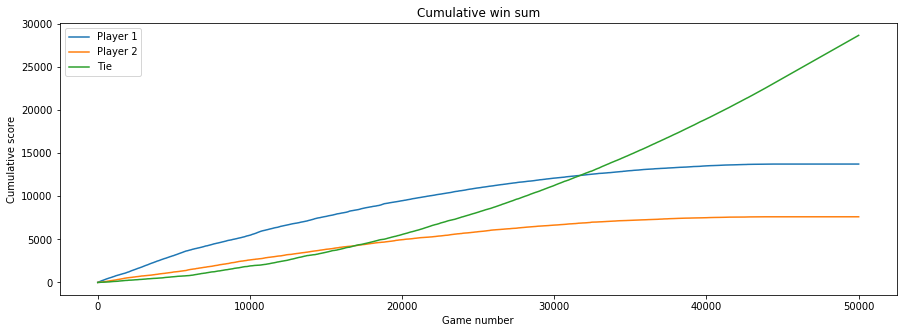

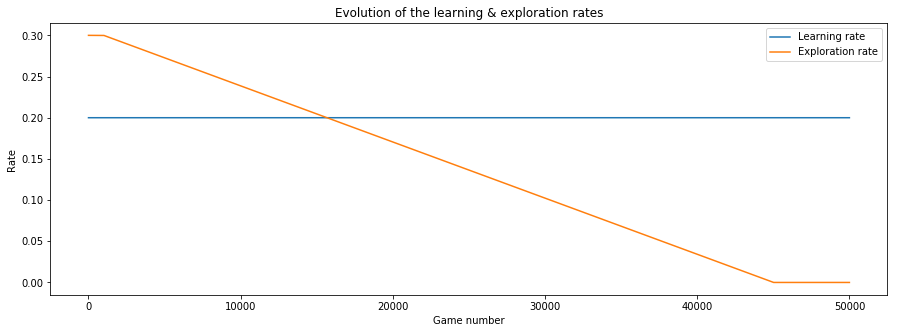

In [8]:
st.displayMetrics()

## Benchmark the policies
In this section, the policies will all play against the one with the largest iteration count in order to quantify their relative performance.

In [9]:
def loadAllPolicies(folder='policies/*'):
    list_policies = glob.glob(folder)
    p1_policies = [p for p in list_policies if p.split('/')[-1].split('_')[0] == 'p1']
    p2_policies = [p for p in list_policies if p.split('/')[-1].split('_')[0] == 'p2']
    return sorted(p1_policies), sorted(p2_policies)

In [10]:
p1_policies, p2_policies = loadAllPolicies()

In [11]:
def compositeScore(results):
    p1win = len(results["p1"])
    p2win = len(results["p2"])
    tie = len(results["tie"])
    return p1win - p2win

In [12]:
def benchmarkPolicies():
    nb_games = 100
    p1win = np.zeros((len(p1_policies), len(p2_policies)), dtype=np.int8)
    p2win = np.zeros((len(p1_policies), len(p2_policies)), dtype=np.int8)
    tie = np.zeros((len(p1_policies), len(p2_policies)), dtype=np.int8)
    for idxp1, policy_p1 in enumerate(p1_policies):
        for idxp2, policy_p2 in enumerate(p2_policies):
            # 1. Create players and load respective policies
            p1 = Player("p1", 1, pc1, WIN, exp_rate=0)
            p1.loadPolicy(policy_p1)
            p2 = Player("p2", 2, pc2, WIN, exp_rate=0)
            p2.loadPolicy(policy_p2)

            # 2. Play 100 games
            st = State(p1, p2)
            st.play(rounds=nb_games, save_policies=False)

            # 3. Store the results
            assert st.results["played"] == nb_games
            p1win[idxp1, idxp2] = len(st.results['p1'])
            p2win[idxp1, idxp2] = len(st.results['p2'])
            tie[idxp1, idxp2] = len(st.results['tie'])
    return p1win, p2win, tie

In [13]:
p1win, p2win, tie = benchmarkPolicies()

In [14]:
print("P1 win matrix:\n", p1win)
print("P2 win matrix:\n", p2win)
print("Tie matrix:\n", tie)

P1 win matrix:
 [[50 36 64 37 44 29 60 24 32 38 50 32 41 33 30 78 33 23 34 34]
 [76 64 73 39 74 40 78 42 73 39 82 31 64 30 33 85 63 34 75 70]
 [59 39 44 22 53 25 50 21 58 23 39 17 48 20 29 78 46 16 42 52]
 [77 55 85 49 75 35 86 31 73 35 83 36 72 45 36 90 59 27 76 70]
 [68 35 67 40 46 32 55 34 47 30 65 23 47 38 35 69 46 36 39 49]
 [83 68 90 56 78 39 84 43 75 44 91 41 79 34 39 84 75 42 80 73]
 [64 26 63 22 55 36 46 29 50 28 54 24 41 19 25 73 58 28 43 37]
 [89 53 80 49 68 47 83 41 80 37 78 37 78 38 40 88 66 43 73 66]
 [74 36 71 29 71 32 73 28 63 39 71 28 42 29 34 86 49 34 54 49]
 [79 50 73 60 86 44 80 41 77 39 82 52 69 37 43 82 68 42 67 67]
 [48 43 63 22 56 31 48 24 62 30 52 25 57 29 16 80 49 20 42 35]
 [79 49 85 43 80 37 83 39 82 36 86 39 69 46 37 89 73 41 68 67]
 [85 32 69 29 75 31 80 36 68 34 85 28 66 42 31 84 42 31 66 57]
 [74 57 80 53 85 43 86 43 75 45 88 45 65 37 42 85 77 45 68 69]
 [82 76 84 64 77 41 76 51 80 36 85 45 62 44 49 84 63 47 57 78]
 [70 26 38 41 54 24 47 14 41 23 55 34 3

In [15]:
p1 = Player("p1", 1, pc1, WIN, exp_rate=0)
p1.loadPolicy("policies/p1_5000")

p2 = Player("p2", 2, pc2, WIN, exp_rate=0)
p2.loadPolicy("policies/p2_1000")

st = State(p1, p2)
st.play(save_policies=None)

TypeError: play() got an unexpected keyword argument 'savePolicies'

In [ ]:
p1.savePolicy()
p2.savePolicy()

In [ ]:
p1.loadPolicy("policy_p1")

### Human vs Computer

In [18]:
p1 = Player("computer", 1, pc1, WIN, exp_rate=0)
p1.loadPolicy("policies/p1_50000")

p2 = HumanPlayer("Human", 2, pc2, WIN)

st = State(p1, p2)
st.playComputerVsHuman()

-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
Input your action row:1
Input your action col:1
-------------
|   |   | x | 
-------------
|   | o |   | 
-------------
|   |   |   | 
-------------
-------------
| x |   | x | 
-------------
|   | o |   | 
-------------
|   |   |   | 
-------------
Input your action row:0
Input your action col:1
-------------
| x | o | x | 
-------------
|   | o |   | 
-------------
|   |   |   | 
-------------
-------------
| x | o | x | 
-------------
|   | o |   | 
-------------
|   |   | x | 
-------------
Input your action row:1
Input your action col:2
-------------
| x | o | x | 
-------------
|   | o | o | 
-------------
|   |   | x | 
-------------
-------------
| x | o | x | 
-------------
|   | o | o | 
-------------
|   | x | x | 
-------------
Input your action row:1
Input your action col:0
-------------
| x | o | x | 
-------------
| o | o | o | 
-------------
|   | x | x | 
-------------
